# Dropout
Dropout [1] is a technique for regularizing neural networks by randomly setting some features to zero during the forward pass. In this exercise you will implement a dropout layer and modify your fully-connected network to optionally use dropout.

[1] Geoffrey E. Hinton et al, "Improving neural networks by preventing co-adaptation of feature detectors", arXiv 2012

In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = 'assignment2'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/assignment2/cs231n/datasets
--2021-10-02 22:02:32--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  29.7MB/s    in 6.1s    

2021-10-02 22:02:38 (26.6 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1
/content/drive/My Drive/assignment2


In [2]:
# As usual, a bit of setup

import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [3]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.iteritems():
  print '%s: ' % k, v.shape

X_val:  (1000, 3, 32, 32)
X_train:  (49000, 3, 32, 32)
X_test:  (1000, 3, 32, 32)
y_val:  (1000,)
y_train:  (49000,)
y_test:  (1000,)


# Dropout forward pass
In the file `cs231n/layers.py`, implement the forward pass for dropout. Since dropout behaves differently during training and testing, make sure to implement the operation for both modes.

Once you have done so, run the cell below to test your implementation.

In [18]:
x = np.random.randn(500, 500) + 10

for p in [0.3, 0.6, 0.75]:
  out, _ = dropout_forward(x, {'mode': 'train', 'p': p})
  out_test, _ = dropout_forward(x, {'mode': 'test', 'p': p})

  print 'Running tests with p = ', p
  print 'Mean of input: ', x.mean()
  print 'Mean of train-time output: ', out.mean()
  print 'Mean of test-time output: ', out_test.mean()
  print 'Fraction of train-time output set to zero: ', (out == 0).mean()
  print 'Fraction of test-time output set to zero: ', (out_test == 0).mean()

Running tests with p =  0.3
Mean of input:  9.9984694384465
Mean of train-time output:  6.858888959671518
Mean of test-time output:  7.278777775614348
Fraction of train-time output set to zero:  0.314
Fraction of test-time output set to zero:  0.272
Running tests with p =  0.6
Mean of input:  9.9984694384465
Mean of train-time output:  3.797941313732416
Mean of test-time output:  3.839506372049613
Fraction of train-time output set to zero:  0.62
Fraction of test-time output set to zero:  0.616
Running tests with p =  0.75
Mean of input:  9.9984694384465
Mean of train-time output:  2.120775312627386
Mean of test-time output:  2.419077232112947
Fraction of train-time output set to zero:  0.788
Fraction of test-time output set to zero:  0.758


# Dropout backward pass
In the file `cs231n/layers.py`, implement the backward pass for dropout. After doing so, run the following cell to numerically gradient-check your implementation.

In [19]:
x = np.random.randn(10, 10) + 10
dout = np.random.randn(*x.shape)

dropout_param = {'mode': 'train', 'p': 0.8, 'seed': 123}
out, cache = dropout_forward(x, dropout_param)
dx = dropout_backward(dout, cache)
dx_num = eval_numerical_gradient_array(lambda xx: dropout_forward(xx, dropout_param)[0], x, dout)

print 'dx relative error: ', rel_error(dx, dx_num)

dx relative error:  1.8928938493018932e-11


# Fully-connected nets with Dropout
In the file `cs231n/classifiers/fc_net.py`, modify your implementation to use dropout. Specificially, if the constructor the the net receives a nonzero value for the `dropout` parameter, then the net should add dropout immediately after every ReLU nonlinearity. After doing so, run the following to numerically gradient-check your implementation.

In [23]:
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for dropout in [0, 0.25, 0.5]:
  print 'Running check with dropout = ', dropout
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            weight_scale=5e-2, dtype=np.float64,
                            dropout=dropout, seed=123)

  loss, grads = model.loss(X, y)
  print 'Initial loss: ', loss

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print '%s relative error: %.2e' % (name, rel_error(grad_num, grads[name]))
  print

Running check with dropout =  0
Initial loss:  2.3025939213171194
W1 relative error: 1.98e-06
W2 relative error: 8.10e-07
W3 relative error: 1.74e-07
b1 relative error: 3.90e-08
b2 relative error: 1.04e-08
b3 relative error: 1.48e-10

Running check with dropout =  0.25
Initial loss:  2.3036966390239595
W1 relative error: 8.41e-06
W2 relative error: 6.11e-06
W3 relative error: 2.43e-06
b1 relative error: 2.06e-07
b2 relative error: 4.90e-09
b3 relative error: 9.98e-11

Running check with dropout =  0.5
Initial loss:  2.3000847525385097
W1 relative error: 2.40e-06
W2 relative error: 3.66e-07
W3 relative error: 4.62e-08
b1 relative error: 2.62e-08
b2 relative error: 1.85e-09
b3 relative error: 1.25e-10



# Regularization experiment
As an experiment, we will train a pair of two-layer networks on 500 training examples: one will use no dropout, and one will use a dropout probability of 0.75. We will then visualize the training and validation accuracies of the two networks over time.

In [26]:
# Train two identical nets, one with dropout and one without

num_train = 500
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}
dropout_choices = [0, 0.75]
for dropout in dropout_choices:
  model = FullyConnectedNet([500], dropout=dropout)
  print dropout

  solver = Solver(model, small_data,
                  num_epochs=50, batch_size=100,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 5e-4,
                  },
                  verbose=True, print_every=100)
  solver.train()
  solvers[dropout] = solver

0
(Iteration 1 / 250) loss: 6.549360
(Epoch 0 / 50) train acc: 0.236000; val_acc: 0.163000
(Epoch 1 / 50) train acc: 0.338000; val_acc: 0.228000
(Epoch 2 / 50) train acc: 0.534000; val_acc: 0.270000
(Epoch 3 / 50) train acc: 0.574000; val_acc: 0.278000
(Epoch 4 / 50) train acc: 0.640000; val_acc: 0.259000
(Epoch 5 / 50) train acc: 0.754000; val_acc: 0.272000
(Epoch 6 / 50) train acc: 0.772000; val_acc: 0.270000
(Epoch 7 / 50) train acc: 0.836000; val_acc: 0.280000
(Epoch 8 / 50) train acc: 0.882000; val_acc: 0.280000
(Epoch 9 / 50) train acc: 0.862000; val_acc: 0.259000
(Epoch 10 / 50) train acc: 0.900000; val_acc: 0.271000
(Epoch 11 / 50) train acc: 0.926000; val_acc: 0.291000
(Epoch 12 / 50) train acc: 0.938000; val_acc: 0.284000
(Epoch 13 / 50) train acc: 0.956000; val_acc: 0.291000
(Epoch 14 / 50) train acc: 0.972000; val_acc: 0.271000
(Epoch 15 / 50) train acc: 0.972000; val_acc: 0.275000
(Epoch 16 / 50) train acc: 1.000000; val_acc: 0.291000
(Epoch 17 / 50) train acc: 0.986000; v

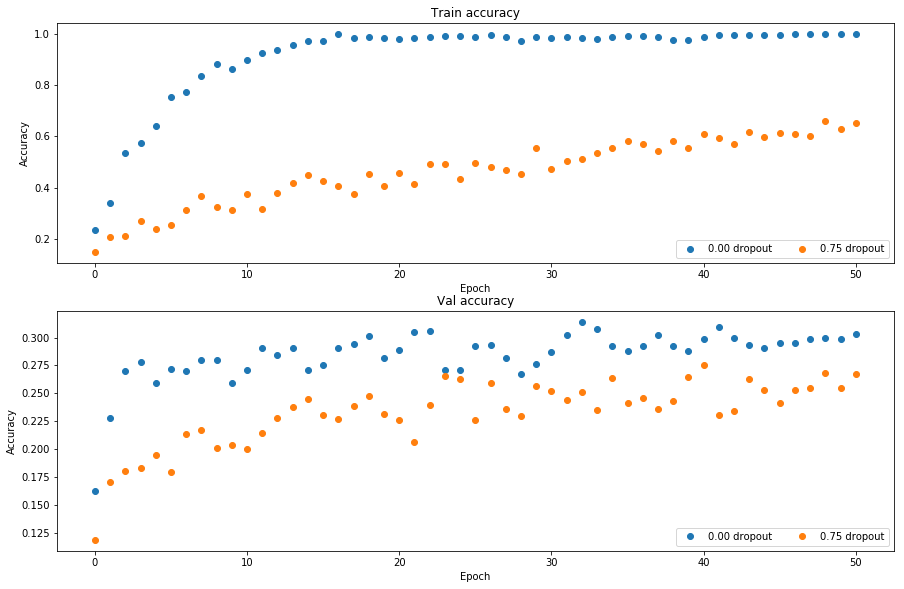

In [27]:
# Plot train and validation accuracies of the two models

train_accs = []
val_accs = []
for dropout in dropout_choices:
  solver = solvers[dropout]
  train_accs.append(solver.train_acc_history[-1])
  val_accs.append(solver.val_acc_history[-1])

plt.subplot(3, 1, 1)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].train_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')
  
plt.subplot(3, 1, 2)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].val_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(15, 15)
plt.show()

# Question
Explain what you see in this experiment. What does it suggest about dropout?

# Answer
